In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import gzip
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
from functools import partial

import torch
from torch.nn import init
from torch import nn
from torch import tensor
from torch.optim import SGD
import torch.nn.functional as F

from fastai import datasets
from exp.utils import accuracy
from exp.learner import Learner
#from exp.hooks import Hook, append_stats
from exp.cnn import conv2d_layer
from exp.optimizer import SgdOptimizer
from exp.callbacks import AvgStatsCallback, ProgressCallback, Recorder, CudaCallback, BatchTransformCallBack, view_trans, HookCallBack, append_stats
from exp.data import normalize_to, Dataset, DataBunch, get_dls
from exp.module import Lambda

## Get Data

In [3]:
def get_data(mb=True):
    if mb:
        fname = "/home/ricky/Desktop/repos/fastai_course/course_2/data/mnist/mnist.pkl.gz"
    else:
        fname = "/Users/ricardofernandez/.fastai/data/mnist/mnist.pkl.gz"
    
    path = datasets.download_data(
        url="http://deeplearning.net/data/mnist/mnist.pkl",
        fname=fname, ext=".gz")
    
    with gzip.open(path, "rb") as f:
        ((x_train, y_train), (x_test, y_test), _) = pickle.load(f, encoding="latin-1")
        
    return map(tensor, (x_train, y_train, x_test, y_test))

x_train, y_train, x_valid, y_valid = get_data(mb=False)

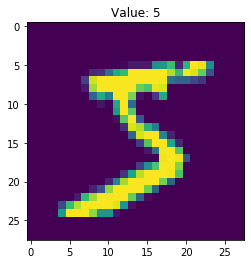

In [4]:
plt.imshow(x_train[0].view(28,28))
plt.title(f"Value: {y_train[0]}");

In [5]:
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [6]:
batch_size = 512
num_classes = y_train.max().item() + 1
data = DataBunch(*get_dls(train_ds, valid_ds, batch_size), num_classes)

In [7]:
data.train_ds is train_ds

True

In [8]:
x, y = next(iter(data.train_dl))
x.shape, y.shape

(torch.Size([512, 784]), torch.Size([512]))

## Model 

In [9]:
def flatten(x):
    return x.view(x.shape[0], -1)

In [10]:
def get_cnn_layers(data, filters, layers, **kwargs):
    filters = [1] + filters
    return [layers(filters[i], filters[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(filters)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(filters[-1], data.c)
    ]

def get_cnn_model(data, filters, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, filters, layer, **kwargs))

filters = [8, 16, 32, 32]
model = get_cnn_model(data, filters, conv2d_layer)

In [11]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [12]:
list(model.children())

[Sequential(
   (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (1): ReLU()
 ), Sequential(
   (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ), Sequential(
   (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ), Sequential(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ), AdaptiveAvgPool2d(output_size=1), Lambda(), Linear(in_features=32, out_features=10, bias=True)]

## Loss Function

In [13]:
loss = F.cross_entropy

## Optimizer

In [14]:
sgd = SgdOptimizer(model.parameters())
sgd

torch.Size([8, 1, 5, 5])
torch.Size([8])
torch.Size([16, 8, 3, 3])
torch.Size([16])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])

## Callbacks 

In [15]:
callbacks = [ProgressCallback,
             partial(AvgStatsCallback, accuracy),
             CudaCallback,
             partial(BatchTransformCallBack, view_trans(1, 28, 28)),
             partial(HookCallBack, append_stats)]

## Learner 

In [36]:
model = get_cnn_model(data, filters, conv2d_layer)
for l in model:
    if isinstance(l, nn.Sequential):
        init.xavier_normal_(l[0].weight)
        l[0].bias.data.zero_()
        
learn = Learner(model, data, loss, lr=0.4, cb_funcs=callbacks, opt_func=SGD)
learn.fit(4)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.729960,0.427400,0.508538,0.840100,00:05
1,0.326193,0.901320,0.181761,0.945000,00:05
2,0.185517,0.944040,0.139091,0.955000,00:05
3,0.126121,0.961500,0.108677,0.966700,00:05


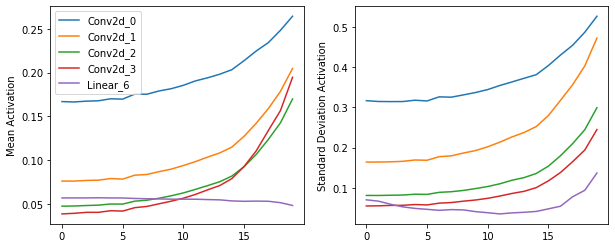

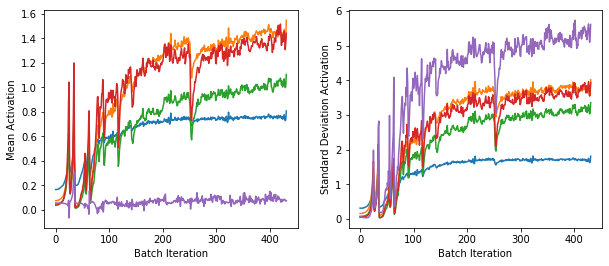

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
for h in learn.hook_call_back.hooks:
    axes[0].plot(h.stats[0][:20])
    axes[1].plot(h.stats[1][:20])
    h.remove()
axes[0].legend(learn.hook_call_back.hook_names)
axes[0].set_ylabel("Mean Activation")
axes[1].set_ylabel("Standard Deviation Activation")

fig, axes = plt.subplots(1, 2, figsize=(10,4))
for h in learn.hook_call_back.hooks:
    axes[0].plot(h.stats[0])
    axes[1].plot(h.stats[1])
    h.remove()
axes[0].set_ylabel("Mean Activation")
axes[0].set_xlabel("Batch Iteration")
axes[1].set_ylabel("Standard Deviation Activation")
axes[1].set_xlabel("Batch Iteration");

## Kaiming 

In [38]:
model2 = get_cnn_model(data, filters, conv2d_layer)
for l in model2:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

learn2 = Learner(model2, data, loss, lr=0.4, cb_funcs=callbacks, opt_func=SGD)
learn2.fit(4)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.026039,0.661160,0.228504,0.933000,00:05
1,0.212560,0.936040,0.143357,0.956000,00:05
2,0.130564,0.960240,0.106755,0.967200,00:05
3,0.097941,0.970420,0.096343,0.971500,00:05


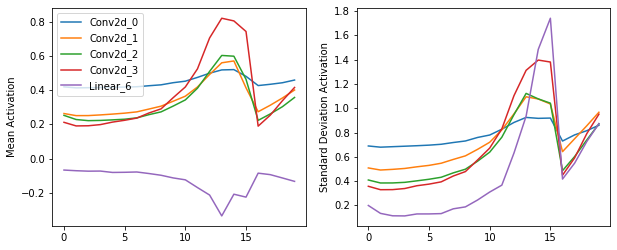

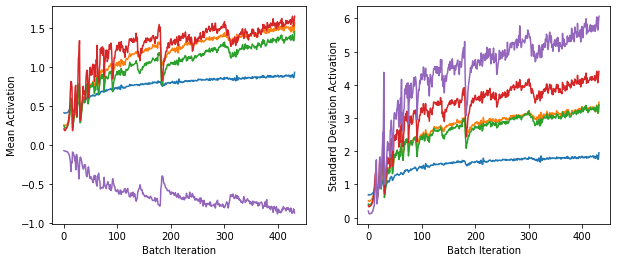

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
for h in learn2.hook_call_back.hooks:
    axes[0].plot(h.stats[0][:20])
    axes[1].plot(h.stats[1][:20])
    h.remove()
axes[0].legend(learn2.hook_call_back.hook_names)
axes[0].set_ylabel("Mean Activation")
axes[1].set_ylabel("Standard Deviation Activation")

fig, axes = plt.subplots(1, 2, figsize=(10,4))
for h in learn2.hook_call_back.hooks:
    axes[0].plot(h.stats[0])
    axes[1].plot(h.stats[1])
    h.remove()
axes[0].set_ylabel("Mean Activation")
axes[0].set_xlabel("Batch Iteration")
axes[1].set_ylabel("Standard Deviation Activation")
axes[1].set_xlabel("Batch Iteration");